In [249]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import nltk

import spacy 
from sklearn import metrics
from sklearn.decomposition import PCA 
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split 
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer

from wordcloud import WordCloud
from collections import Counter
from nltk import word_tokenize, FreqDist
import re
import string

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing import text, sequence
from keras import initializers, regularizers, constraints, optimizers, layers
from keras.models import Model, Input, Sequential
from keras.layers import GRU, Dense, Input, LSTM, Embedding, Dropout, SpatialDropout1D, Activation
from keras.layers import Conv1D, Bidirectional, GlobalMaxPool1D, MaxPooling1D, BatchNormalization
from keras.optimizers import Adam
from keras.layers import Input, Dense, LSTM, Embedding
from keras.layers import Dropout, Activation, Bidirectional, GlobalMaxPool1D
from keras.models import Model
from keras import initializers, regularizers, constraints, optimizers, layers
from keras.preprocessing import text, sequence
from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping

from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
from time import time

import glob
import xgboost as xgb

In [2]:
import warnings
warnings.filterwarnings('ignore')

# In this Notebook

- Cleaning of steam game data

- Exploratory Data Analysis for both steam datasets
    - Wordclouds for descriptions
    - Wordcluods by genre
    - Wordcounts for descriptions
    


In [3]:
steam_data = pd.read_csv('Steam_DETAILED_DATA_cleaned.csv')

In [4]:
steam_data.head()

,Name,ReleaseDate,ReleaseYear,Metacritic,RecommendationCount,SteamSpyOwners,SteamSpyOwnersVariance,SteamSpyPlayersEstimate,SteamSpyPlayersVariance,IsFree,...,GenreIsSimulation,GenreIsEarlyAccess,GenreIsFreeToPlay,GenreIsSports,GenreIsRacing,GenreIsMassivelyMultiplayer,PriceCurrency,PriceFinal,AboutText,Reviews
0,Counter-Strike,Nov 1 2000,2000,88,68991,13033334,92789,9140731,78136,False,...,False,False,False,False,False,False,USD,9.99,Play the worlds number 1 online action game. E...,
1,Team Fortress Classic,Apr 1 1999,1999,0,2439,5399140,60368,753627,22699,False,...,False,False,False,False,False,False,USD,4.99,One of the most popular online action games of...,
2,Day of Defeat,May 1 2003,2003,79,2319,7621102,71499,1709740,34145,False,...,False,False,False,False,False,False,USD,4.99,Enlist in an intense brand of Axis vs. Allied ...,
3,Deathmatch Classic,Jun 1 2001,2001,0,888,7498965,70936,789676,23235,False,...,False,False,False,False,False,False,USD,4.99,Enjoy fast-paced multiplayer gaming with Death...,
4,Half-Life: Opposing Force,Nov 1 1999,1999,0,2934,5399499,60370,705741,21968,False,...,False,False,False,False,False,False,USD,4.99,Return to the Black Mesa Research Facility as ...,


In [5]:
steam_data.columns

Index(['Name', 'ReleaseDate', 'ReleaseYear', 'Metacritic',
       'RecommendationCount', 'SteamSpyOwners', 'SteamSpyOwnersVariance',
       'SteamSpyPlayersEstimate', 'SteamSpyPlayersVariance', 'IsFree',
       'PurchaseAvail', 'SubscriptionAvail', 'PlatformWindows',
       'PlatformLinux', 'PlatformMac', 'PCReqsHaveMin', 'PCReqsHaveRec',
       'LinuxReqsHaveMin', 'LinuxReqsHaveRec', 'MacReqsHaveMin',
       'MacReqsHaveRec', 'CategorySinglePlayer', 'CategoryMultiplayer',
       'CategoryCoop', 'CategoryMMO', 'CategoryInAppPurchase',
       'CategoryIncludeSrcSDK', 'CategoryIncludeLevelEditor',
       'CategoryVRSupport', 'GenreIsNonGame', 'GenreIsIndie', 'GenreIsAction',
       'GenreIsAdventure', 'GenreIsCasual', 'GenreIsStrategy', 'GenreIsRPG',
       'GenreIsSimulation', 'GenreIsEarlyAccess', 'GenreIsFreeToPlay',
       'GenreIsSports', 'GenreIsRacing', 'GenreIsMassivelyMultiplayer',
       'PriceCurrency', 'PriceFinal', 'AboutText', 'Reviews'],
      dtype='object')

In [6]:
steam_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13357 entries, 0 to 13356
Data columns (total 46 columns):
Name                           13357 non-null object
ReleaseDate                    13357 non-null object
ReleaseYear                    13357 non-null object
Metacritic                     13357 non-null int64
RecommendationCount            13357 non-null int64
SteamSpyOwners                 13357 non-null int64
SteamSpyOwnersVariance         13357 non-null int64
SteamSpyPlayersEstimate        13357 non-null int64
SteamSpyPlayersVariance        13357 non-null int64
IsFree                         13357 non-null bool
PurchaseAvail                  13357 non-null bool
SubscriptionAvail              13357 non-null bool
PlatformWindows                13357 non-null bool
PlatformLinux                  13357 non-null bool
PlatformMac                    13357 non-null bool
PCReqsHaveMin                  13357 non-null bool
PCReqsHaveRec                  13357 non-null bool
LinuxReqsHav

**Summary of Useful Columns**
- Name - Name of game
- Release Date - Full release date stored as string
- Release Year - Year of release stored as a number
- Metacritic - Score on metacritic (as of 2016 when data was pulled)
- RecommendationCount - How many times the game has been recommended to users via steam's recommedation engine
- SteamSpyOwners - Number of owners of the game per steamspy.com API as of 2016
- SteamSpyOwnersVariance - Variance in number of owners over time since games release as of 2016
- IsFree - Whether or not the game is free
- GenreIsXXXX - Whether the game has that genre tag or not (boolean)
- PriceFinal - Final price of the game
- AboutText - Verbal description of the game
- Reviews - Short review text. Usually just one review but occasionally there are several reviews in the same string


**Preprocessing Notes**

Through review of the data, there are several issues that need to be corrected during preprocessing before any sort of EDA or modeling can be done.

- Reviews, although appearing as non-null for all data, have a ton of missing data where spaces are used as placeholders. Need to remove these or at least make them appear as NaN
- Games in this dataset have more than one Genre, most games have at least 3 "genres" that they fall into. 
    - Will probably just exclude genre from this analysis
- Because some steam games are released on multiple computer platforms (Windows, Linux, Mac). There are several duplicates in the dataframe. Even for these cases, the statistics for each row are the same. I.E. Half-Life 2's release on Linux and Windows show same statistics
    - I will remove all duplicates from this dataframe
- For games released in 2016 when this data was scraped, there is a large number of games missing any sort of data. These games 

In [7]:
steam_data['SteamSpyOwners'].median()

9506.0

In [8]:
# Creating a revenue estimate using final price and steam spy owners
steam_data['Revenue_Estimate'] = steam_data['SteamSpyPlayersEstimate'] * steam_data['PriceFinal']

In [9]:
steam_data['Revenue_Estimate'].max()

377004076.28000003

In [10]:
steam_data['Revenue_Estimate'].mean()

1364651.504498765

In [30]:
# Dropping 2016 values where data is missing (replaced with 0s)
steam_data.drop(steam_data.loc[steam_data['SteamSpyOwners'] == 0].index, inplace=True)

In [99]:
# Dropping duplicates
steam_data.drop_duplicates(subset=['Name'], inplace=True)

In [184]:
len(steam_data)

10508

In [101]:
steam_data.to_csv('preprocessed_steam_data.csv')

In [12]:
explore_me = steam_data[['Name', 'SteamSpyOwners', 'Revenue_Estimate']]

In [13]:
explore_me.sort_values(by='SteamSpyOwners', ascending=False).head(20)

,Name,SteamSpyOwners,Revenue_Estimate
23,Dota 2,90687580,0.000000e+00
20,Team Fortress 2,37878812,0.000000e+00
4028,Unturned,27025292,0.000000e+00
27,Counter-Strike: Global Offensive,25833156,3.770041e+08
22,Left 4 Dead 2,15574539,2.715322e+08
11,Counter-Strike: Source,15433570,2.293451e+08
15,Half-Life 2: Lost Coast,14844765,0.000000e+00
2115,Warframe,14497544,0.000000e+00
14,Half-Life 2: Deathmatch,14001822,1.795816e+07
0,Counter-Strike,13033334,9.131590e+07


My initial idea was to use these revenue numbers and compare them to console revenue in the other dataset. However, I learned a few things from reading about steamspy's methodology (the source of the data).

- Owned does not mean sold. Owned games include bought on steam, bought in retail and activated on steam, bought in bundles, received through promotions, received as a gift, copies given away on free weekends.
    - In other words, it is almost impossible to make revenue conclusions based solely on "owned" figures

## Establishing "Hit" Steam Games

In [33]:
steam_data['SteamSpyOwners'].describe()

count    1.061900e+04
mean     2.098696e+05
std      1.260542e+06
min      5.330000e+02
25%      4.663000e+03
50%      1.829400e+04
75%      9.559300e+04
max      9.068758e+07
Name: SteamSpyOwners, dtype: float64

In [34]:
steam_data['SteamSpyOwners'].median()

18294.0

## For purposes of this analysis, I'll consider a steam game a "Hit" if it is owned by more than 100,000 individuals. This is roughly the Q3 (75%) value. I'll denote a flop as any game owned by less than 5,000 individuals. This is roughly the Q1 (25%) value. Anything in between will be denoted as "Average

In [53]:
# Creating hit or not column
steam_data.loc[steam_data['SteamSpyOwners'] >= 100000, 'Hit_or_not'] = 'Hit'
steam_data.loc[(steam_data['SteamSpyOwners'] < 100000) & (steam_data['SteamSpyOwners'] > 5000), 'Hit_or_not'] = 'Average'
steam_data.loc[steam_data['SteamSpyOwners'] <= 5000, 'Hit_or_not'] = 'Flop'

In [54]:
len(steam_data.loc[steam_data['SteamSpyOwners'] >= 500000])

852

In [55]:
# Turning that to 1s and 0s. Could also be done using LabelEncoder
steam_data.loc[steam_data['Hit_or_not'] =='Hit', 'BINARY_Hits'] = 2
steam_data.loc[steam_data['Hit_or_not'] =='Average', 'BINARY_Hits'] = 1
steam_data.loc[steam_data['Hit_or_not'] =='Flop', 'BINARY_Hits'] = 0

In [56]:
steam_data['BINARY_Hits'].value_counts()

1.0    5288
0.0    2749
2.0    2582
Name: BINARY_Hits, dtype: int64

# NLP Analysis: About Text & Review Text

Given that it is so difficult to make revenue deductions from the steam dataset, I decided to explore the about text for each game, and see if I could build a model that could read the about text for a game and predict whether or not it would be a "hit" (distribute over 60,000 copies). Below, I do preprocessing and exploratory data analysis for the "about" text and for any games that have reviews in the steam game dataset.

## Visualizing About Text in Word Clouds

In [205]:
steam_data.columns

Index(['Name', 'ReleaseDate', 'ReleaseYear', 'Metacritic',
       'RecommendationCount', 'SteamSpyOwners', 'SteamSpyOwnersVariance',
       'SteamSpyPlayersEstimate', 'SteamSpyPlayersVariance', 'IsFree',
       'PurchaseAvail', 'SubscriptionAvail', 'PlatformWindows',
       'PlatformLinux', 'PlatformMac', 'PCReqsHaveMin', 'PCReqsHaveRec',
       'LinuxReqsHaveMin', 'LinuxReqsHaveRec', 'MacReqsHaveMin',
       'MacReqsHaveRec', 'CategorySinglePlayer', 'CategoryMultiplayer',
       'CategoryCoop', 'CategoryMMO', 'CategoryInAppPurchase',
       'CategoryIncludeSrcSDK', 'CategoryIncludeLevelEditor',
       'CategoryVRSupport', 'GenreIsNonGame', 'GenreIsIndie', 'GenreIsAction',
       'GenreIsAdventure', 'GenreIsCasual', 'GenreIsStrategy', 'GenreIsRPG',
       'GenreIsSimulation', 'GenreIsEarlyAccess', 'GenreIsFreeToPlay',
       'GenreIsSports', 'GenreIsRacing', 'GenreIsMassivelyMultiplayer',
       'PriceCurrency', 'PriceFinal', 'AboutText', 'Reviews',
       'Revenue_Estimate', 'Hit_or_n

In [206]:
about_text_df = steam_data[['Name', 'AboutText', 'BINARY_Hits', 'GenreIsAction',
       'GenreIsAdventure', 'GenreIsCasual', 'GenreIsStrategy', 'GenreIsRPG',
       'GenreIsSimulation', 'GenreIsEarlyAccess', 'GenreIsFreeToPlay',
       'GenreIsSports']]

In [207]:
about_text_df.head()

,Name,AboutText,BINARY_Hits,GenreIsAction,GenreIsAdventure,GenreIsCasual,GenreIsStrategy,GenreIsRPG,GenreIsSimulation,GenreIsEarlyAccess,GenreIsFreeToPlay,GenreIsSports
0,Counter-Strike,Play the worlds number 1 online action game. E...,2.0,True,False,False,False,False,False,False,False,False
1,Team Fortress Classic,One of the most popular online action games of...,2.0,True,False,False,False,False,False,False,False,False
2,Day of Defeat,Enlist in an intense brand of Axis vs. Allied ...,2.0,True,False,False,False,False,False,False,False,False
3,Deathmatch Classic,Enjoy fast-paced multiplayer gaming with Death...,2.0,True,False,False,False,False,False,False,False,False
4,Half-Life: Opposing Force,Return to the Black Mesa Research Facility as ...,2.0,True,False,False,False,False,False,False,False,False


In [208]:
#First, I need to take out any punctuation and stop words that will muddy up the wordclouds
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [218]:
#Defining stop words to remove
from nltk.corpus import stopwords
stop = stopwords.words('english')

In [255]:
# Removing what I call video game stop words, or words that appear in almost every about text
stop.extend(['game', 'play', 'world', 'players', 'player', 'new', 'one'])

In [256]:
stop

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

In [257]:
# Building a clean_text function that will lowercase, remove punctuation, and return the cleaned text
def clean_text(text):
    #Replaces all punctuation with spaces and lowercases all words
    text = re.sub('[{}]'.format(string.punctuation), ' ', text.lower())
    #Removes stopwords
    return ' '.join([word for word in text.split() if word not in (stop)])

In [221]:
about_text_df['cleaned_text'] = list(map(lambda t: clean_text(t), about_text_df['AboutText']))

In [222]:
# Checking for NAs
about_text_df['cleaned_text'].isna().sum()

0

In [223]:
text = " ".join(text for text in about_text_df['cleaned_text'])

In [224]:
wordcloud = WordCloud(background_color="white", max_words=150, max_font_size=100).generate(text)

Text(0.5, 1.0, 'Wordcloud for ALL Games')

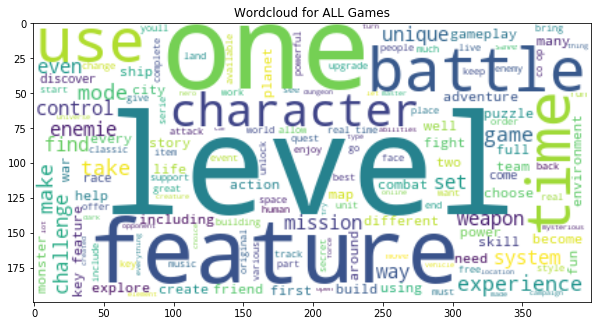

In [225]:
#Trying first wordcloud- this is for ALL projects- successful and non-successful
fig = plt.figure(figsize = (10,8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Wordcloud for ALL Games')

In [226]:
#Wordcloud for just HIT games
text_hits = " ".join(text for text in about_text_df.loc[about_text_df['BINARY_Hits'] == 2, 'cleaned_text'])
wordcloud_hits = WordCloud(background_color="white", max_words=150, max_font_size=100).generate(text_hits)

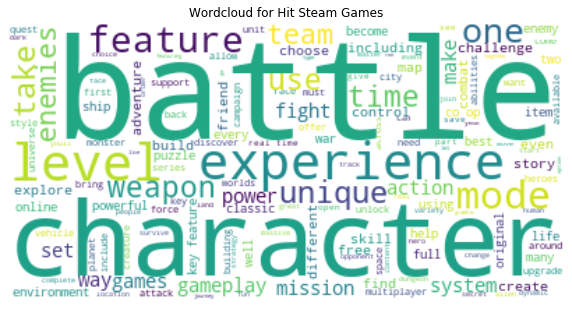

In [227]:
#Visualization of hits wordcloud
fig = plt.figure(figsize = (10,8))
plt.imshow(wordcloud_hits, interpolation='bilinear')
plt.title('Wordcloud for Hit Steam Games')
plt.axis('off')
fig.show()

In [228]:
#Wordcloud for just FLOP games
text_flops = " ".join(text for text in about_text_df.loc[about_text_df['BINARY_Hits'] == 0, 'cleaned_text'])
wordcloud_flops = WordCloud(background_color="white", max_words=150, max_font_size=100).generate(text_flops)

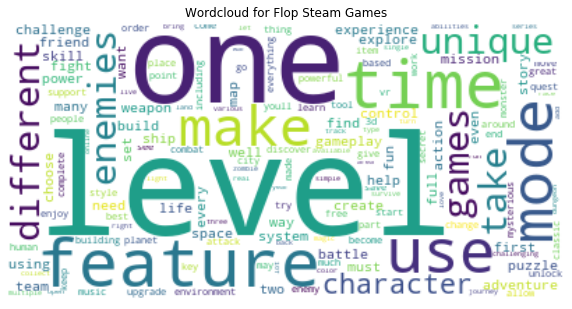

In [229]:
#Visualization of flop wordcloud
fig = plt.figure(figsize = (10,8))
plt.imshow(wordcloud_flops, interpolation='bilinear')
plt.title('Wordcloud for Flop Steam Games')
plt.axis('off')
fig.show()

Unfortunately, using a simple wordcloud visualization to look at hit vs. flops yields no discernable differences. Let's take a look at the top 10 words in each.

In [230]:
# Function to process the text
def process_blurb(blurb):
    tokens = nltk.word_tokenize(blurb)
    list_of_tokens = [token.lower() for token in tokens]
    return list_of_tokens

In [231]:
# Creating list of tokens for failed projects
flops_processed_data = list(map(process_blurb, about_text_df.loc[about_text_df['BINARY_Hits'] == 0, 'cleaned_text']))

# Creating list of tokens for successful projects
hits_processed_data = list(map(process_blurb, about_text_df.loc[about_text_df['BINARY_Hits'] == 2, 'cleaned_text']))

In [232]:
#Creating list so I can use FreqDist on each set
flops_blurbs_concat = []
for blurb in flops_processed_data:
    flops_blurbs_concat += blurb
    
hits_blurbs_concat = []
for blurb in hits_processed_data:
    hits_blurbs_concat += blurb

In [233]:
flop_about_text_freqdist = FreqDist(flops_blurbs_concat)
flop_about_text_freqdist.most_common(20)

[('time', 1557),
 ('one', 1365),
 ('different', 1322),
 ('features', 1288),
 ('levels', 1182),
 ('unique', 1074),
 ('use', 1017),
 ('like', 1003),
 ('enemies', 1002),
 ('games', 983),
 ('find', 966),
 ('way', 962),
 ('mode', 953),
 ('get', 946),
 ('story', 939),
 ('experience', 898),
 ('level', 883),
 ('make', 822),
 ('take', 819),
 ('based', 788)]

In [234]:
hit_about_text_freqdist = FreqDist(hits_blurbs_concat)
hit_about_text_freqdist.most_common(20)

[('features', 1563),
 ('time', 1491),
 ('unique', 1482),
 ('experience', 1397),
 ('one', 1283),
 ('mode', 1160),
 ('weapons', 1146),
 ('battle', 1083),
 ('action', 1080),
 ('system', 1062),
 ('gameplay', 1045),
 ('combat', 1038),
 ('take', 1025),
 ('multiplayer', 1025),
 ('different', 1019),
 ('use', 993),
 ('online', 986),
 ('games', 962),
 ('key', 934),
 ('enemies', 932)]

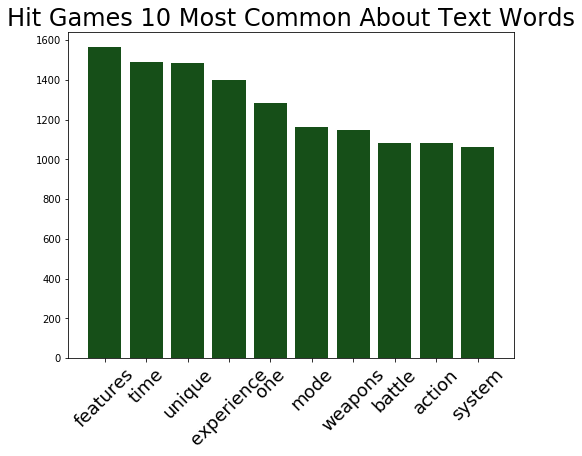

In [235]:
success_word_list = []
success_count_list= [] 
for word, count in hit_about_text_freqdist.most_common(10):
    success_word_list.append(word)
    success_count_list.append(count)
    
plt.figure(figsize = (8,6))
success_count_df = pd.DataFrame({'Word': success_word_list, 'Count':success_count_list})
plt.bar(success_count_df['Word'], success_count_df['Count'], color='#164f18')
plt.title('Hit Games 10 Most Common About Text Words', fontsize=24)
plt.xticks(fontsize=18, rotation=45)
plt.show()

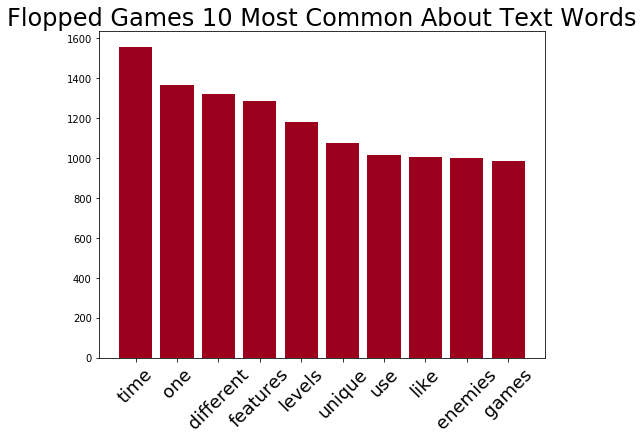

In [236]:
#Failure word count visualization

failure_word_list = []
failure_count_list= [] 
for word, count in flop_about_text_freqdist.most_common(10):
    failure_word_list.append(word)
    failure_count_list.append(count)
    
plt.figure(figsize = (8,6))
failure_count_df = pd.DataFrame({'Word': failure_word_list, 'Count':failure_count_list})
plt.bar(failure_count_df['Word'], failure_count_df['Count'], color='#9b001c')
plt.title('Flopped Games 10 Most Common About Text Words', fontsize=24)
plt.xticks(fontsize=18, rotation=45)
plt.show()

In [237]:
failure_word_list

['time',
 'one',
 'different',
 'features',
 'levels',
 'unique',
 'use',
 'like',
 'enemies',
 'games']

## Finding words that were in hit game about texts, but NOT in flop games

In [238]:
# Resetting lists to get top 30 words

failure_word_list = []
failure_count_list= [] 
# 30 instead of 10 above
for word, count in flop_about_text_freqdist.most_common(40):
    failure_word_list.append(word)
    failure_count_list.append(count)
    
success_word_list = []
success_count_list= [] 
for word, count in hit_about_text_freqdist.most_common(40):
    success_word_list.append(word)
    success_count_list.append(count)

In [239]:
hit_words_df = pd.DataFrame(list(zip(success_word_list, success_count_list)), columns=['word', 'hit_count'])

In [240]:
flop_words_df = pd.DataFrame(list(zip(failure_word_list, failure_count_list)), columns=['word', 'flop_count'])

In [241]:
combined_words_df = pd.merge(hit_words_df, flop_words_df, how='outer')

In [242]:
combined_words_df.head()

,word,hit_count,flop_count
0,features,1563.0,1288.0
1,time,1491.0,1557.0
2,unique,1482.0,1074.0
3,experience,1397.0,898.0
4,one,1283.0,1365.0


In [243]:
unique_hit_words = combined_words_df.loc[combined_words_df['flop_count'].isnull()]

In [244]:
unique_hit_words

,word,hit_count,flop_count
11,combat,1038.0,NaN
13,multiplayer,1025.0,NaN
16,online,986.0,NaN
18,key,934.0,NaN
22,team,853.0,NaN
30,including,763.0,NaN
31,character,758.0,NaN
35,war,733.0,NaN
36,2,717.0,NaN


In [245]:
unique_flop_words = combined_words_df.loc[combined_words_df['hit_count'].isnull()]

In [246]:
unique_flop_words

,word,hit_count,flop_count
40,find,NaN,966.0
41,level,NaN,883.0
42,many,NaN,708.0
43,help,NaN,695.0
44,even,NaN,636.0
45,full,NaN,620.0
46,life,NaN,611.0
47,space,NaN,600.0
48,explore,NaN,592.0


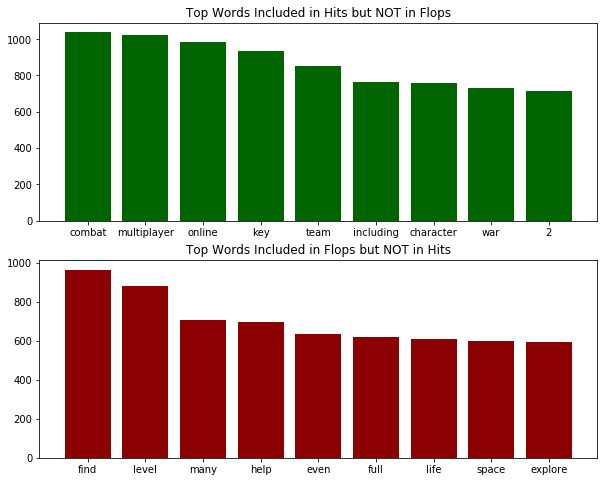

In [247]:
fig=plt.figure(figsize=(10,8))
ax1 = fig.add_subplot(2,1,1)
ax1.bar(unique_hit_words['word'], unique_hit_words['hit_count'], color='darkgreen')
ax1.set_title('Top Words Included in Hits but NOT in Flops')
ax2 = fig.add_subplot(2,1,2)
ax2.bar(unique_flop_words['word'], unique_flop_words['flop_count'], color='darkred')
ax2.set_title('Top Words Included in Flops but NOT in Hits')
plt.show()

## Visualizing length of about text in flops vs. hits

In [89]:
#Creating new blurb length feature which will contain the length of each blurb in words
about_text_df['text_length'] = about_text_df['AboutText'].str.split().str.len()

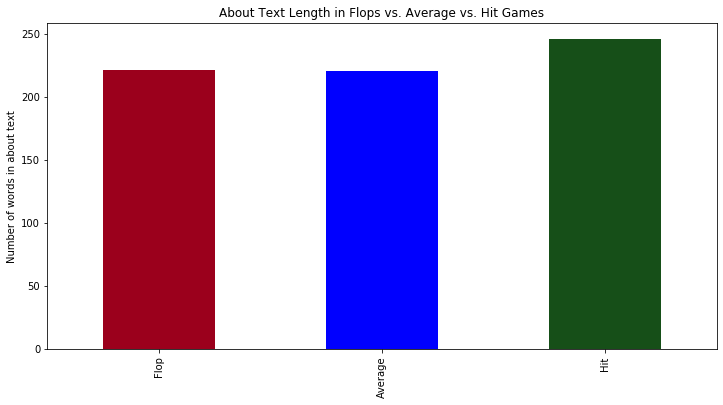

In [97]:
plt.figure(figsize=(12,6))
about_text_df.groupby('BINARY_Hits')['text_length'].mean().plot(kind='bar', color=['#9b001c', 'blue', '#164f18'])
plt.xlabel('')
plt.ylabel('Number of words in about text')
plt.title('About Text Length in Flops vs. Average vs. Hit Games')
plt.xticks(np.arange(3), ('Flop', 'Average', 'Hit'))
plt.show()

## Visualizing About Text by Genre


In [212]:
genre_columns = ['GenreIsAction',
       'GenreIsAdventure', 'GenreIsCasual', 'GenreIsStrategy', 'GenreIsRPG',
       'GenreIsSimulation', 'GenreIsEarlyAccess', 'GenreIsFreeToPlay',
       'GenreIsSports']

In [213]:
genre_columns

['GenreIsAction',
 'GenreIsAdventure',
 'GenreIsCasual',
 'GenreIsStrategy',
 'GenreIsRPG',
 'GenreIsSimulation',
 'GenreIsEarlyAccess',
 'GenreIsFreeToPlay',
 'GenreIsSports']

In [216]:
about_text_df.loc[about_text_df[genre] == True]

,Name,AboutText,BINARY_Hits,GenreIsAction,GenreIsAdventure,GenreIsCasual,GenreIsStrategy,GenreIsRPG,GenreIsSimulation,GenreIsEarlyAccess,GenreIsFreeToPlay,GenreIsSports,cleaned_text
240,Cabelas(r) Big Game Hunter(tm) Trophy Bucks,Your Trophy Buck is Waiting!Experience fast pa...,1.0,False,False,False,False,False,False,False,False,True,trophy buck waiting experience fast paced hunt...
270,GTR 2 FIA GT Racing Game,The Game That Revolutionized the Racing Genre....,1.0,False,False,False,False,False,True,False,False,True,game revolutionized racing genre successor int...
316,3D Ultra(tm) Minigolf Adventures,Whether youre a seasoned player or just a begi...,1.0,False,False,False,False,False,False,False,False,True,whether youre seasoned player beginner get rea...
328,Beijing 2008(tm) - The Official Video Game of ...,Embrace the competitive spirit of the worlds m...,0.0,False,False,False,False,False,False,False,False,True,embrace competitive spirit worlds prestigious ...
399,Hunting Unlimited 2010,Get the Shot. Get the Game. Experience fast-p...,1.0,False,False,False,False,False,True,False,False,True,get shot get game experience fast paced huntin...
447,AaAaAA!!! - A Reckless Disregard for Gravity,Looking for the Oculus Rift version? Want to B...,2.0,True,False,False,False,False,False,False,False,True,looking oculus rift version want base jump mac...
449,AaaaaAAaaaAAAaaAAAAaAAAAA!!! for the Awesome,AaaaaAAaaaAAAaaAAAAaAAAAA!!! for the Awesome i...,2.0,True,False,False,False,False,False,False,False,True,aaaaaaaaaaaaaaaaaaaaaaaaa awesome semi sequel ...
477,Trials 2: Second Edition,RedLynx Trials 2 Second Edition is a spectacul...,2.0,False,False,False,False,False,False,False,False,True,redlynx trials 2 second edition spectacular mo...
478,Monster Trucks Nitro,Race jump and nitroboost your way pass thrilli...,1.0,False,False,False,False,False,False,False,False,True,race jump nitroboost way pass thrilling dynami...
521,Zero Gear,Zero Gear is physically-fueled online multipla...,2.0,True,False,False,False,False,False,False,False,True,zero gear physically fueled online multiplayer...


In [ ]:
text_genre = " ".join(text for text in about_text_df.loc[about_text_df[genre] == True, 'cleaned_text'])
    wordcloud_genre = WordCloud(background_color="white", max_words=150, max_font_size=100).generate(text_genre)
    #Visualization of flop wordcloud
    fig = plt.figure(figsize = (10,8))
    plt.imshow(wordcloud_genre, interpolation='bilinear')
    plt.title('Wordcloud for {genre}')
    plt.axis('off')
    fig.show()

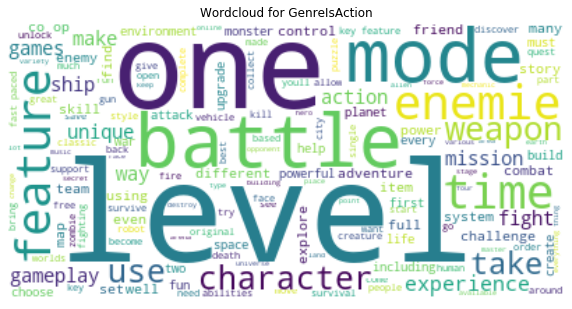

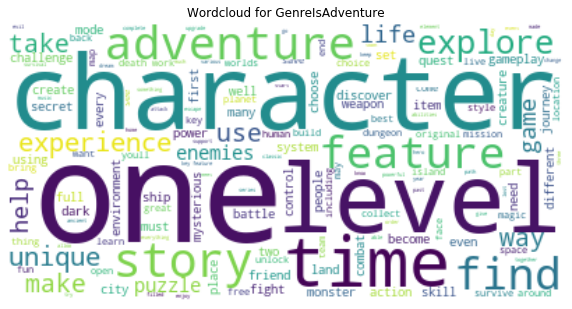

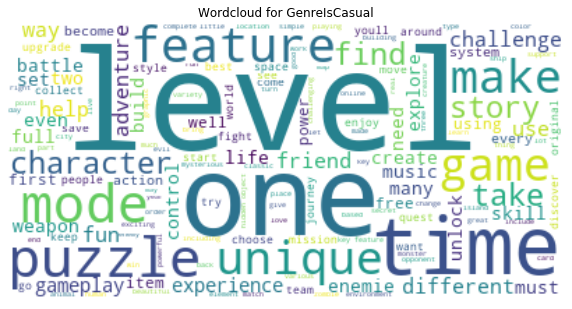

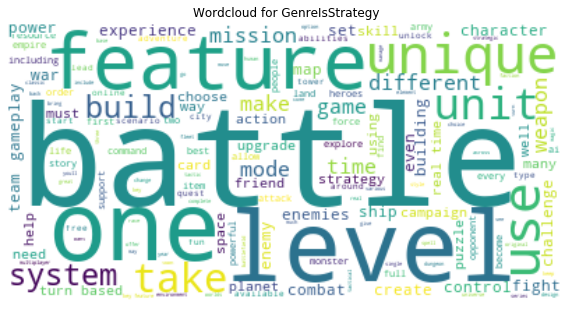

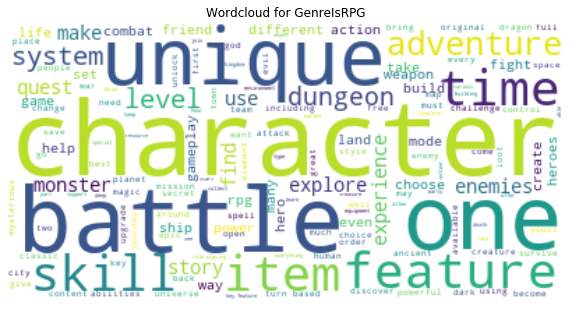

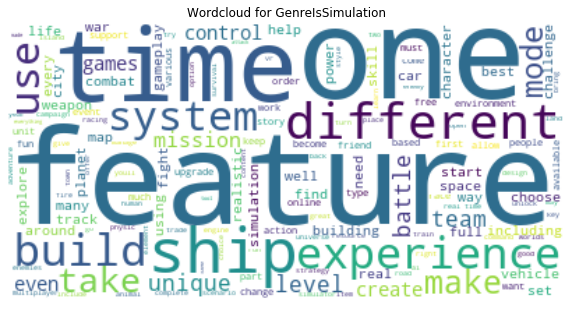

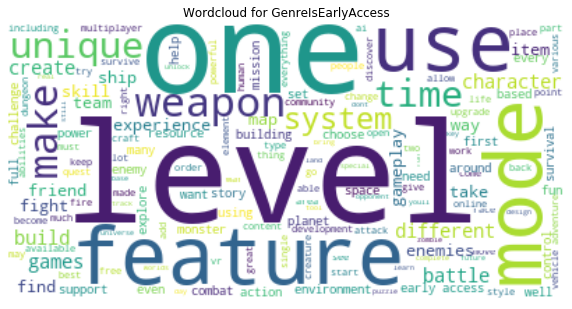

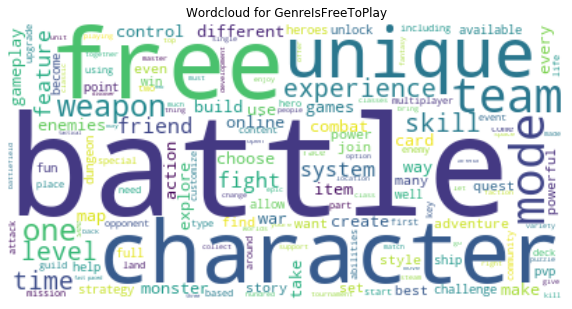

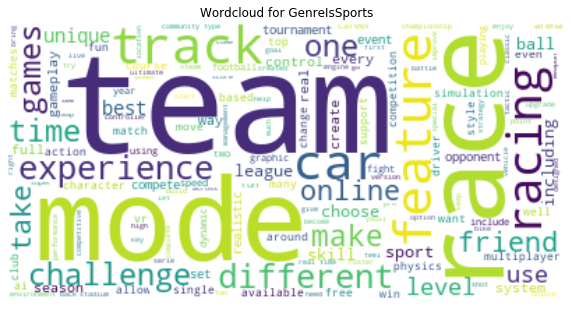

In [248]:
for genre in genre_columns:
    #Wordcloud for just HIT games
    text_genre = " ".join(text for text in about_text_df.loc[about_text_df[genre] == True, 'cleaned_text'])
    wordcloud_genre = WordCloud(background_color="white", max_words=150, max_font_size=100).generate(text_genre)
    #Visualization of flop wordcloud
    fig = plt.figure(figsize = (10,8))
    plt.imshow(wordcloud_genre, interpolation='bilinear')
    plt.title('Wordcloud for {}'.format(genre))
    plt.axis('off')
    fig.show()

Unfortunately, not too much information gained through the genre analysis, as most words are similar.

This analysis is also not that useful because many games are placed in multiple categories on steam, therefore there is overlap between each wordcloud. 

I will retry this when I combine the datasets and have only one genre per game (as opposede to multiple like in this dataset).

**NLP EDA Conclusions**

Very difficult to see any differences. The most noticeable difference comes in the top 20 most used words for hits vs. flops. Words like the following seem to be more highly correlated with releasing a hit game. 

- experience
- battle
- action
- system
- combat
- gameplay

It is tough to draw many conclusions from this, and perhaps the machine learning model will do a better job than the naked eye! However, here are some rough conclusions...

- Players enjoy being told about how the game mechanics work and what gaemplay is like
- Player enjoy reading about the combat system and action
- Players seem indifferent to gaming words such as "game, new, world, play, and mode."
- A slightly longer blurb might help entice users to try the game, especially if that description contains detailed and interesting text about the in game fighting mechanics.

**Recommendation**: A good description of a game will focus on the gameplay mechanics and highlight exciting and unique experiences that the Publisher can deliver to the user. 

In [98]:
about_text_df.to_csv('About_text_df.csv', index=False)

## Review Text EDA

In [176]:
# Examining reviews since I suspect not all of them actually have reviews but placeholders instead
steam_data['Reviews'].nunique()

3048

In [179]:
steam_data['Reviews'].value_counts().sort_values(ascending=False).head()

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     7451
Whether you are playing Dead Island: Definitive Edition or Dead Island Riptide: Definitive Edition the gameplay is stunning fast-paced and a whole lot of fun. This remaster is packed with content and value for gamers and is one Id recommend regardless if youve played it before or have yet to do so.5 / 5 - ExaminerDead Island and Dead Island Riptide have never looked so good.7 / 10 - IGN                                                                                         

In [180]:
# So there are 7,451 blank spaces that I need to remove. I'll just create a dataframe for this
has_review_df = steam_data.loc[steam_data['Reviews'] != " "]

In [182]:
has_review_df.head()

,Name,ReleaseDate,ReleaseYear,Metacritic,RecommendationCount,SteamSpyOwners,SteamSpyOwnersVariance,SteamSpyPlayersEstimate,SteamSpyPlayersVariance,IsFree,...,GenreIsSports,GenreIsRacing,GenreIsMassivelyMultiplayer,PriceCurrency,PriceFinal,AboutText,Reviews,Revenue_Estimate,Hit_or_not,BINARY_Hits
29,Red Orchestra: Ostfront 41-45,Mar 14 2006,2006,81,1220,940689,25354,515451,18779,False,...,False,False,False,USD,9.99,Fight in the theatre of war that changed the w...,... RO is also one of the markets most unique ...,5149355.49,Hit,2.0
45,Arx Fatalis,Apr 3 2007,2007,77,389,119806,9058,57033,6250,False,...,False,False,False,USD,4.99,This critically acclaimed first-person RPG tak...,IGN Awards Arx Fatalis an 8/10The spell castin...,284594.67,Hit,2.0
47,Earth 2160,Apr 1 2006,2006,73,412,236024,12712,94876,8061,False,...,False,False,False,USD,4.99,After the destruction of the EARTH in 2150 the...,It may not replace Star Craft in terms of stat...,473431.24,Hit,2.0
48,Two Worlds Epic Edition,Apr 30 2009,2009,65,2399,942661,25380,416629,16885,False,...,False,False,False,USD,9.99,... 300 years after Aziraal has been banished ...,The big player alongside Oblivion and Gothic 3...,4162123.71,Hit,2.0
65,The Ship: Murder Party,Jul 11 2006,2006,76,5026,1364671,30520,928313,25187,True,...,False,False,False,USD,9.99,This package includes a tutorial The Ship Sing...,its gameplay and design draw on everything fro...,9273846.87,Hit,2.0


In [185]:
has_review_df.drop_duplicates(subset=['Reviews'], inplace=True)

In [186]:
len(has_review_df)

3047

In [196]:
# Can't use metacritic scores since so many are 0 sadly
len(has_review_df.loc[has_review_df['Metacritic'] == 0])

2064

In [200]:
# Seeing the breakdown of hits vs. average vs. flop 
has_review_df.Hit_or_not.value_counts()

Average    1616
Hit         883
Flop        548
Name: Hit_or_not, dtype: int64

In [250]:
has_review_df['cleaned_review_text'] = list(map(lambda t: clean_text(t), has_review_df['Reviews']))

In [251]:
has_review_df['cleaned_review_text'].head()

29    ro also one markets unique shooters4 5 stars g...
45    ign awards arx fatalis 8 10the spell casting s...
47    may replace star craft terms stature damn clos...
48    big alongside oblivion gothic 3 great rpg 85 g...
65    gameplay design draw everything poirot quake e...
Name: cleaned_review_text, dtype: object

# Wordclouds of reviews for hits vs. flops

In [260]:
#Wordcloud for just HIT games
text_hits = " ".join(text for text in has_review_df.loc[has_review_df['BINARY_Hits'] == 2, 'cleaned_review_text'])
wordcloud_hits = WordCloud(background_color="white", max_words=150, max_font_size=100).generate(text_hits)

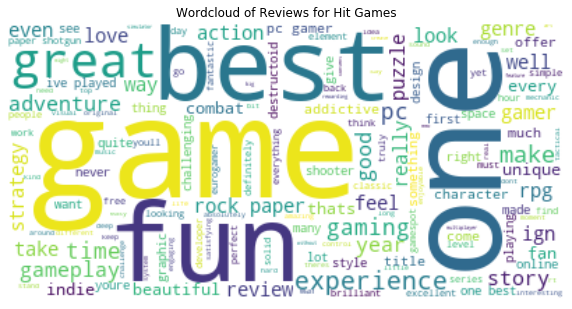

In [261]:
#Visualization of hits wordcloud
fig = plt.figure(figsize = (10,8))
plt.imshow(wordcloud_hits, interpolation='bilinear')
plt.title('Wordcloud of Reviews for Hit Games')
plt.axis('off')
fig.show()

In [203]:
#Wordcloud for just FLOP games
text_flops = " ".join(text for text in has_review_df.loc[has_review_df['BINARY_Hits'] == 0, 'cleaned_review_text'])
wordcloud_flops = WordCloud(background_color="white", max_words=150, max_font_size=100).generate(text_flops)

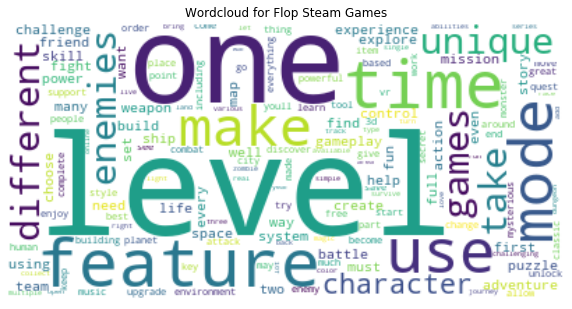

In [258]:
#Visualization of flop wordcloud
fig = plt.figure(figsize = (10,8))
plt.imshow(wordcloud_flops, interpolation='bilinear')
plt.title('Wordcloud of Reviews for Flop Games')
plt.axis('off')
fig.show()

**Reviews**

Unfortunately, there were not too many reviews and most of them seemed positive, or focusing on the gameplay experience.
However, it is clear that several words appear far more often in "hit" reviews than in "flop" reviews